# Introduction to Reservoir Computing and ReservoirPy

**ReservoirPy documentation:** https://reservoirpy.readthedocs.io/en/latest/index.html

In [1]:
%pip install --quiet reservoirpy==0.4.*

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

# Make everything deterministic
rpy.set_seed(2341)

## A simple example: Mackey-Glass

- List of available datasets in ReservoirPy: https://reservoirpy.readthedocs.io/en/latest/api/reservoirpy.datasets.html
- Documentation for the Mackey-Glass dataset: https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.datasets.mackey_glass.html

#### Importing the chaotic timeseries Mackey-Glass

In [3]:
from reservoirpy.datasets import mackey_glass

timeseries = mackey_glass(n_timesteps=2_000)
timeseries.shape

(2000, 1)

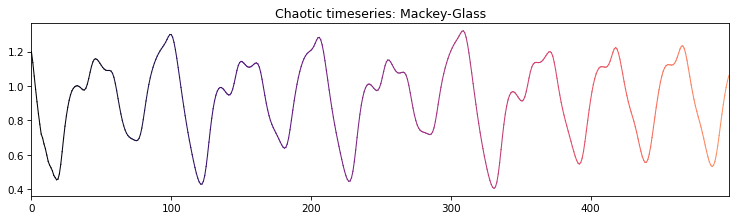

In [4]:
X = timeseries
timesteps = 500
plt.figure(figsize=(12, 3))
for i in range(timesteps-1):
    plt.plot([i, i+1], X[i:i+2, 0], color=plt.cm.magma(200*i//timesteps), lw=1.0)
plt.title("Chaotic timeseries: Mackey-Glass")
plt.show()

#### Data pre-processing

Documentation for the `to_forecasting` method: https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.datasets.to_forecasting.html

X/Y and train/test split

In [5]:
from reservoirpy.datasets import to_forecasting

dataset = to_forecasting(X, forecast=10, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

In [6]:
print(
    x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape,
)

(1590, 1) (400, 1) (1590, 1) (400, 1)


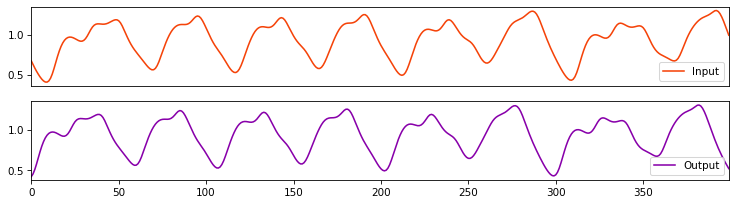

In [7]:
plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test, label="Input")
plt.legend()
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, label="Output", color="#8800AA")
plt.legend()
plt.show()

#### Model creation

ESN documentation: https://reservoirpy.readthedocs.io/en/latest/api/reservoirpy.ESN.html

In [8]:
from reservoirpy import ESN

In [9]:
model = ESN(
    units=100, # neurons inside the reservoir
    lr=0.3, # leak rate
    sr=1.25, # spectral radius of the weight matrix
    ridge=1e-8) # Regularization parameter

#### Fitting and running

In [10]:
model.fit(x_train, y_train) # Learning phase
y_pred = model.run(x_test) # Prediction

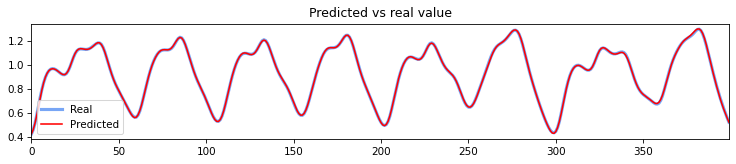

In [11]:
plt.figure(figsize=(12,2))
plt.plot(1)
plt.plot(y_test, label="Real", linewidth=3)
plt.plot(y_pred, label="Predicted", color="red")
plt.title("Predicted vs real value")
plt.legend()
plt.show()

### What about a $t+50$ prediction ?

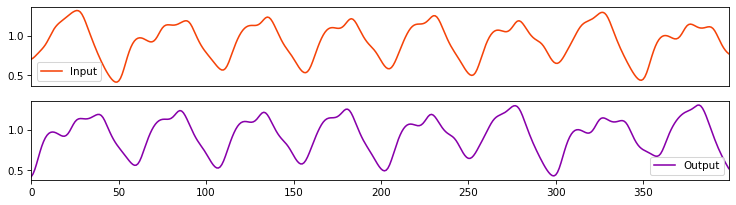

In [12]:
dataset = to_forecasting(X, forecast=50, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test, label="Input")
plt.legend()
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, label="Output", color="#8800AA")
plt.legend()
plt.show()

In [13]:
# Model creation
model = ESN(
    units=100, # neurons inside the reservoir
    lr=0.3, # leak rate
    sr=1.25, # spectral radius of the weight matrix
    ridge=1e-8, # Regularization parameter
)

# Fitting the model
model.fit(x_train, y_train)
# Testing the model
y_pred = model.run(x_test)

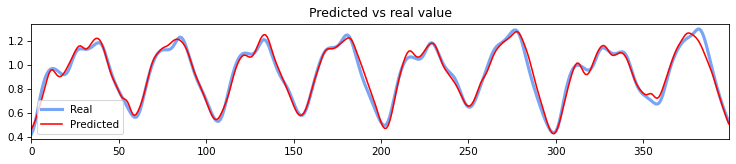

In [14]:
plt.figure(figsize=(12,2))
plt.plot(1)
plt.plot(y_test, label="Real", linewidth=3)
plt.plot(y_pred, label="Predicted", color="red")
plt.title("Predicted vs real value")
plt.legend()
plt.show()

### Summary

In [15]:
model = ESN(
    units=100, # neurons inside the reservoir
    lr=0.3, # leak rate
    sr=1.25, # spectral radius of the weight matrix
    ridge=1e-8, # Regularization parameter
)

# Fitting the model
model.fit(x_train, y_train)
# Testing the model
y_pred = model.run(x_test)

### Listening to the reservoir's heart

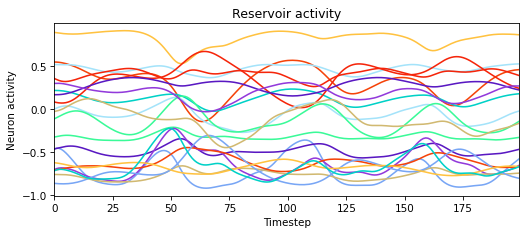

In [16]:
activity = model.reservoir.run(x_test)

plt.figure(figsize=(8, 3))
plt.plot(activity[:200, :20]) # 200 timestep, 20 neurons
plt.title("Reservoir activity")
plt.xlabel("Timestep")
plt.ylabel("Neuron activity")
plt.show()

### The nodes

- Reservoir Node documentation: https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.nodes.Reservoir.html
- Ridge Node documentation: https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.nodes.Ridge.html

In [17]:
# create the reservoir node
reservoir = Reservoir(
    units=100, # neurons inside the reservoir
    lr=0.3, # leak rate
    sr=1.25, # spectral radius of the weight matrix
)
# create the readout node
readout = Ridge(ridge=1e-8) # Regularized linear layer

# connect them together!
model = reservoir >> readout # Connecting the nodes

### Simple forward connection

In [18]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=10)
readout = Ridge(ridge=1e-4)

model = reservoir >> readout

### Feedback connections

- User guide on feedback connections: https://reservoirpy.readthedocs.io/en/latest/user_guide/advanced_demo.html#Feedback-connections

In [19]:
reservoir = Reservoir(units=10)
readout = Ridge(ridge=1e-4)

# create feedback
model = (reservoir >> readout) & (reservoir << readout)  # a forward and a feedback connection

In [20]:
# ESN syntax
model = ESN(units=10, ridge=1e-4, feedback=True)

### `scikit-learn` node

- `ScikitLearnNode` Node documentation: https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.nodes.ScikitLearnNode.html

In [21]:
from reservoirpy.nodes import ScikitLearnNode
from sklearn.linear_model import (
    RidgeClassifier, 
    LogisticRegression,
)
reservoir = Reservoir(units=10)

classifier = ScikitLearnNode(RidgeClassifier)
logistic_regressor = ScikitLearnNode(LogisticRegression)

model1 = reservoir >> classifier
model2 = reservoir >> logistic_regressor

### Creating custom nodes

- User guide on custom node creation: https://reservoirpy.readthedocs.io/en/latest/user_guide/create_new_node.html

In [22]:
import numpy as np
from reservoirpy import Node


class MyNode(Node):
    def __init__(self, a, name=None):
        self.a = a
        self.name = name

    def initialize(self, x):
        # set input_dim & output_dim
        self._set_input_dim(x)
        self.output_dim = self.input_dim
        # define the state
        self.state = {"out": np.zeros((self.output_dim,))}
        # switch the initialized parameter to True
        self.initialized = True

    def _step(self, state, x):
        output_value = x + a
        return {"out": output_value}

    def _run(self, state, x):
        output_series = x + a  # vectorized on the whole series
        return {"out": output_series[-1]}, output_series


my_node = MyNode(a=10)

### Create complex architectures

- Deep and complex architectures: https://reservoirpy.readthedocs.io/en/latest/user_guide/advanced_demo.html#%E2%80%9CDeep%E2%80%9D-architectures

In [23]:
from reservoirpy.nodes import Input, Output, Identity

A, B, C, D, E, F = (Identity() for _ in range(6))

path1, path2 = A >> F, B >> E
# One-to-many connection using a list
path3 = Input() >> [A, B, C]
# Chain of connections
path4 = A >> B >> C >> D >> E >> F >> Output()
# Merge all pathways to create the full computational graph
model = path1 & path2 & path3 & path4

### Hyper-parameter search

Adapted from: https://reservoirpy.readthedocs.io/en/latest/user_guide/hyper.html

In [24]:
# Imports
from reservoirpy.observables import nrmse, rsquare
import json
from reservoirpy.hyper import parallel_research, plot_hyperopt_report

In [25]:
# Configure research
hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [26]:
# Define the objective function
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    instances = config["instances_per_trial"]
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        model = ESN(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling,
            ridge=ridge, 
            seed=variable_seed,
        )
        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        losses.append(nrmse(y_test, predictions))
        r2s.append(rsquare(y_test, predictions))
        
        # Change the seed between instances
        variable_seed += 1

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [27]:
# Start the hyperparameter search
dataset = x_train, x_test, y_train, y_test
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [00:36<00:00,  5.53trial/s, best loss=0.0195]


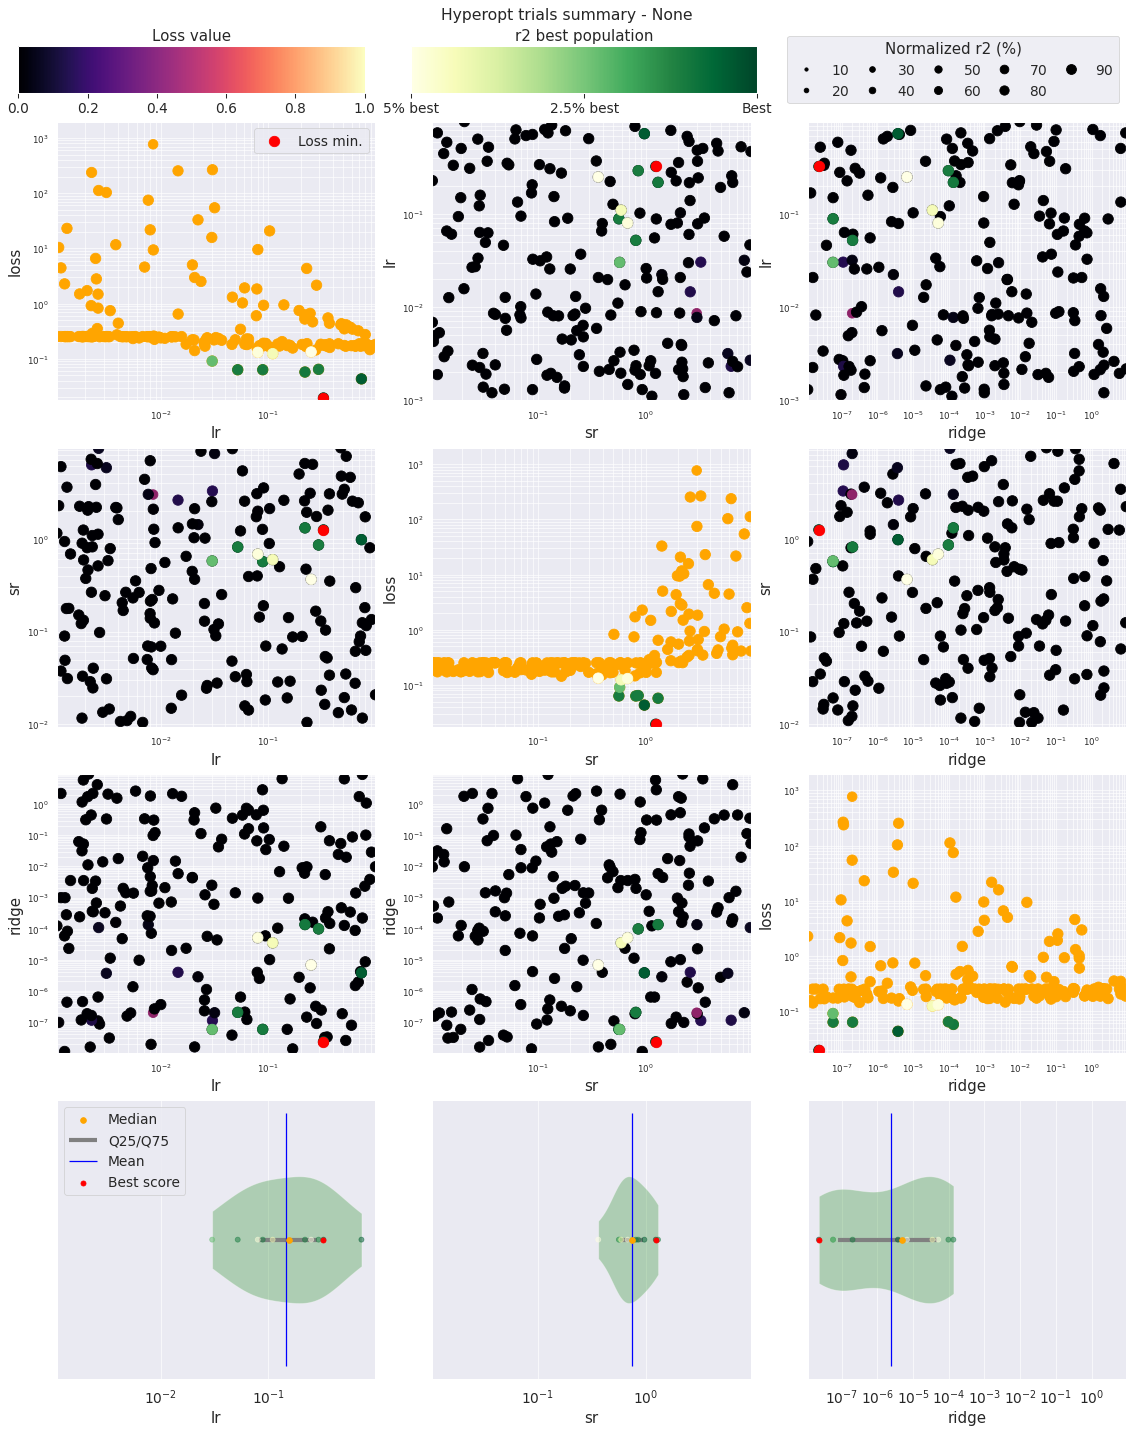

In [28]:
# visualize the results
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

In [29]:
# Interactive report
from interactive_report import interactive_report
interactive_report(hyperopt_config['exp'], ['lr', 'sr', 'ridge'], log_loss=True, out_path='limit.json')